In [1]:
import os
import json
import spacy
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:

# Laden des deutschen Modells von spaCy
nlp = spacy.load("de_core_news_md")

def get_adjective_ratio(text):
    doc = nlp(text)
    total_tokens = len(doc)
    adjectives = sum(1 for token in doc if token.pos_ == "ADJ")
    return adjectives / total_tokens if total_tokens > 0 else 0

def process_folder(folder_path):
    ratios = defaultdict(list)
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            data = json.load(file)
            if data['poem']:
                poem_text = " ".join([line["text"] for line in data["poem"].values()])
                ratio = get_adjective_ratio(poem_text)
                decade = (int(data["author_birth"]) // 10) * 10
                ratios[decade].append(ratio)
    return ratios

def average_ratios(ratios):
    return {decade: (sum(values) / len(values), len(values)) for decade, values in ratios.items() if len(values) > 0}

male_ratios = process_folder(r"corpus_finished_m")
female_ratios = process_folder(r"corpus_finished_w")

male_avg_ratios = average_ratios(male_ratios)
female_avg_ratios = average_ratios(female_ratios)

# Durchschnitt für den gesamten Korpus (m/w getrennt und gesamt)
all_male_ratios = [ratio for ratios in male_ratios.values() for ratio in ratios]
all_female_ratios = [ratio for ratios in female_ratios.values() for ratio in ratios]
all_ratios = all_male_ratios + all_female_ratios

print(f"Durchschnittliche Frequenz von Adjektiven für den gesamten Korpus (Männer): {sum(all_male_ratios) / len(all_male_ratios):.2f}")
print(f"Durchschnittliche Frequenz von Adjektiven für den gesamten Korpus (Frauen): {sum(all_female_ratios) / len(all_female_ratios):.2f}")
print(f"Durchschnittliche Frequenz von Adjektiven für den gesamten Korpus (gesamt): {sum(all_ratios) / len(all_ratios):.2f}")
print()

print("Durchschnittliche Frequenz von Adjektiven für Männer:")
for decade in sorted(male_avg_ratios.keys()):
    avg, count = male_avg_ratios[decade]
    print(f"{decade}s: {avg:.3f} (Anzahl der Gedichte: {count})")

print("\nDurchschnittliche Frequenz von Adjektiven für Frauen:")
for decade in sorted(female_avg_ratios.keys()):
    avg, count = female_avg_ratios[decade]
    print(f"{decade}s: {avg:.3f} (Anzahl der Gedichte: {count})")


Durchschnittliche Frequenz von Substantiven für den gesamten Korpus (Männer): 0.04
Durchschnittliche Frequenz von Substantiven für den gesamten Korpus (Frauen): 0.04
Durchschnittliche Frequenz von Substantiven für den gesamten Korpus (gesamt): 0.04

Durchschnittliche Frequenz von Adjektiven für Männer:
0s: 0.026 (Anzahl der Gedichte: 22)
1870s: 0.052 (Anzahl der Gedichte: 7)
1880s: 0.043 (Anzahl der Gedichte: 9)
1890s: 0.033 (Anzahl der Gedichte: 22)
1900s: 0.042 (Anzahl der Gedichte: 13)
1920s: 0.033 (Anzahl der Gedichte: 93)
1930s: 0.031 (Anzahl der Gedichte: 189)
1940s: 0.035 (Anzahl der Gedichte: 199)
1950s: 0.037 (Anzahl der Gedichte: 219)
1960s: 0.041 (Anzahl der Gedichte: 323)
1970s: 0.043 (Anzahl der Gedichte: 247)
1980s: 0.033 (Anzahl der Gedichte: 107)
1990s: 0.016 (Anzahl der Gedichte: 8)
2010s: 0.000 (Anzahl der Gedichte: 1)

Durchschnittliche Frequenz von Adjektiven für Frauen:
0s: 0.054 (Anzahl der Gedichte: 32)
1900s: 0.043 (Anzahl der Gedichte: 22)
1910s: 0.029 (Anzahl 

In [3]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

def perform_tests(data_m, data_w, sample_name):
    if len(data_m) < 3 or len(data_w) < 3:
        print(f"Tests für {sample_name} können nicht durchgeführt werden, da weniger als 3 Datenpunkte für mindestens eine der Gruppen vorhanden sind.")
        return

    # Überprüfen, ob die Daten normalverteilt sind
    _, p_value_m = shapiro(data_m)
    _, p_value_w = shapiro(data_w)
    alpha = 0.05

    # Wenn beide Daten normalverteilt sind, führen Sie den t-Test durch
    if p_value_m > alpha and p_value_w > alpha:
        stat, p_value = ttest_ind(data_m, data_w)
        print(f"t-Test für {sample_name}:")
    # Andernfalls führen Sie den Whitney U-Test durch
    else:
        stat, p_value = mannwhitneyu(data_m, data_w)
        print(f"Whitney U-Test für {sample_name}:")

    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value < alpha:
        print(f"Es gibt einen signifikanten Unterschied in den Adjektivfrequenzen zwischen Männern und Frauen für {sample_name}.")
    else:
        print(f"Es gibt keinen signifikanten Unterschied in den Adjektivfrequenzen zwischen Männern und Frauen für {sample_name}.")
    print()

# Durchführung der Tests für den gesamten Korpus
perform_tests([value for values in male_ratios.values() for value in values], [value for values in female_ratios.values() for value in values], "gesamter Korpus")

# Durchführung der Tests für jedes Jahrzehnt
for decade in sorted(male_avg_ratios.keys()):
    male_decade_frequencies = [ratio for ratio in male_ratios[decade]]
    female_decade_frequencies = [ratio for ratio in female_ratios.get(decade, [])]  # Verwenden Sie get(), um einen Standardwert zurückzugeben, wenn das Jahrzehnt nicht vorhanden ist
    perform_tests(male_decade_frequencies, female_decade_frequencies, f"{decade}s")


Whitney U-Test für gesamter Korpus:
Teststatistik: 633226.0
p-Wert: 1.100404905160691e-05
Es gibt einen signifikanten Unterschied in den Adjektivfrequenzen zwischen Männern und Frauen für gesamter Korpus.

Whitney U-Test für 0s:
Teststatistik: 195.0
p-Wert: 0.005848611880792498
Es gibt einen signifikanten Unterschied in den Adjektivfrequenzen zwischen Männern und Frauen für 0s.

Tests für 1870s können nicht durchgeführt werden, da weniger als 3 Datenpunkte für mindestens eine der Gruppen vorhanden sind.
Tests für 1880s können nicht durchgeführt werden, da weniger als 3 Datenpunkte für mindestens eine der Gruppen vorhanden sind.
Tests für 1890s können nicht durchgeführt werden, da weniger als 3 Datenpunkte für mindestens eine der Gruppen vorhanden sind.
Whitney U-Test für 1900s:
Teststatistik: 159.0
p-Wert: 0.5966678715469491
Es gibt keinen signifikanten Unterschied in den Adjektivfrequenzen zwischen Männern und Frauen für 1900s.

Whitney U-Test für 1920s:
Teststatistik: 1521.0
p-Wert: 

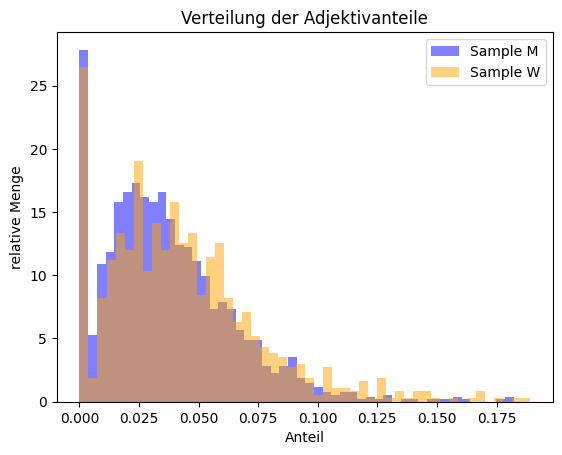

In [4]:
# Erstelle eine Figure und Axes-Objekte
fig, ax = plt.subplots()

# Plotten der Histogramme für beide Subsamples
ax.hist(all_male_ratios, bins=50, alpha=0.5, label='Sample M', color='blue', density=True)
ax.hist(all_female_ratios, bins=50, alpha=0.5, label='Sample W', color='orange', density=True)

# Hinzufügen von Labels und Titeln
ax.set_xlabel('Anteil')
ax.set_ylabel('relative Menge')
ax.set_title('Verteilung der Adjektivanteile')

# Legende anzeigen
ax.legend()

# Anzeigen der Grafik
plt.show()